In [1]:
'''
In terminal:
1. Open folder where you want to create the virtual environment
2. Run "python3 -m venv env_name" to create a virtual environment named "env_name"
3. Run "source env_name/bin/activate" to activate the virtual environment

In VSC:
1. Open Command Palette(Ctrl+Shift+P) and type "Python: Select Interpreter"
2. Select the python interpreter that you want to use
3. Select Kernel: Restart Kernel and Clear All Outputs
'''

'\nIn terminal:\n1. Open folder where you want to create the virtual environment\n2. Run "python3 -m venv env_name" to create a virtual environment named "env_name"\n3. Run "source env_name/bin/activate" to activate the virtual environment\n\nIn VSC:\n1. Open Command Palette(Ctrl+Shift+P) and type "Python: Select Interpreter"\n2. Select the python interpreter that you want to use\n3. Select Kernel: Restart Kernel and Clear All Outputs\n'

In [2]:
## Instalowanie modułów

!pip3 install --upgrade pip

!pip3 install -U numpy
!pip3 install -U matplotlib
!pip3 install -U scikit-learn
!pip3 install -U pandas
!pip3 install -U openpyxl

In [3]:
## Importowanie modułów

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, accuracy_score


In [4]:
# Sample code from scikit-learn.org

# digits = load_digits()
# print(digits.data.shape)

# plt.gray()
# plt.matshow(digits.images[0])
# plt.show()

In [5]:
## Przygotowanie danych

# Ładowanie danych
digits = load_digits()
X = digits.data
y = digits.target

# Normalizacja danych
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Podział danych na zbiory treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Konwersja etykiet na postać one-hot
def one_hot_encode(y, num_classes):
    one_hot = np.zeros((y.shape[0], num_classes))
    one_hot[np.arange(y.shape[0]), y] = 1
    return one_hot

y_train_one_hot = one_hot_encode(y_train, 10)
y_test_one_hot = one_hot_encode(y_test, 10)

In [6]:
## Funkcje aktywacji

# ReLU
def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return np.where(x > 0, 1, 0)

# Sigmoid
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    sx = sigmoid(x)
    return sx * (1 - sx)


In [7]:
def initialize_parameters(layer_dims):
    parameters = {}
    L = len(layer_dims)
    
    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) * 0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
    return parameters

In [8]:
## Przejście do przodu

def forward_propagation(X, parameters, activation_func):
    cache = {'A0': X}
    L = len(parameters) // 2
    
    for l in range(1, L+1):
        W = parameters['W' + str(l)]
        b = parameters['b' + str(l)]
        A_prev = cache['A' + str(l-1)]
        
        Z = np.dot(W, A_prev.T) + b
        Z = Z.T
        
        if l == L:
            A = sigmoid(Z)
        else:
            A = activation_func(Z)
        
        cache['Z' + str(l)] = Z
        cache['A' + str(l)] = A
    
    return A, cache


In [9]:
## Przejście do tyłu

def backward_propagation(y, parameters, cache, activation_derivative):
    grads = {}
    L = len(parameters) // 2
    m = y.shape[0]
    
    dA = cache['A' + str(L)] - y
    dZ = dA * sigmoid_derivative(cache['Z' + str(L)])
    
    for l in reversed(range(1, L+1)):
        A_prev = cache['A' + str(l-1)] if l > 1 else cache['A0']
        dW = np.dot(dZ.T, A_prev) / m
        db = np.sum(dZ, axis=0, keepdims=True).T / m
        
        grads['dW' + str(l)] = dW
        grads['db' + str(l)] = db
        
        if l > 1:
            dA = np.dot(dZ, parameters['W' + str(l)])
            dZ = dA * activation_derivative(cache['Z' + str(l-1)])
    
    return grads


In [10]:
## SGD

def update_parameters(parameters, grads, learning_rate):
    L = len(parameters) // 2
    
    for l in range(1, L+1):
        parameters['W' + str(l)] -= learning_rate * grads['dW' + str(l)]
        parameters['b' + str(l)] -= learning_rate * grads['db' + str(l)]
    
    return parameters

In [11]:
## Uczenie sieci

def train(X, y, layer_dims, learning_rate=0.01, num_epochs=1000, batch_size=32, activation_func=relu, activation_derivative=relu_derivative):
    parameters = initialize_parameters(layer_dims)
    m = X.shape[0]
    
    for epoch in range(num_epochs):
        shuffled_indices = np.random.permutation(m)
        X_shuffled = X[shuffled_indices]
        y_shuffled = y[shuffled_indices]
        
        for i in range(0, m, batch_size):
            X_batch = X_shuffled[i:i+batch_size]
            y_batch = y_shuffled[i:i+batch_size]
            
            y_pred, cache = forward_propagation(X_batch, parameters, activation_func)
            grads = backward_propagation(y_batch, parameters, cache, activation_derivative)
            parameters = update_parameters(parameters, grads, learning_rate)
        
        if epoch % 100 == 0:
            predictions = np.argmax(y_pred, axis=1)
            labels = np.argmax(y_batch, axis=1)
            accuracy = accuracy_score(labels, predictions)
            f1 = f1_score(labels, predictions, average='micro')
            print(f"Epoch {epoch} - Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")
    
    return parameters


In [12]:
## Ewaluacja sieci

def evaluate(X, y, parameters, activation_func):
    y_pred, _ = forward_propagation(X, parameters, activation_func)
    predictions = np.argmax(y_pred, axis=1)
    labels = np.argmax(y, axis=1)
    accuracy = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='micro')
    return accuracy, f1

# Parametry sieci
layer_dims = [64, 32, 16, 10]
learning_rate = 0.01
num_epochs = 1000
batch_size = 32

# Trenowanie sieci
parameters = train(X_train, y_train_one_hot, layer_dims, learning_rate, num_epochs, batch_size, activation_func=relu, activation_derivative=relu_derivative)

# Ewaluacja na zbiorze testowym
accuracy, f1 = evaluate(X_test, y_test_one_hot, parameters, relu)
print(f"Test Accuracy: {accuracy:.4f}, Test F1 Score: {f1:.4f}")


Epoch 0 - Accuracy: 0.1111, F1 Score: 0.1111
Epoch 100 - Accuracy: 0.1111, F1 Score: 0.1111
Epoch 200 - Accuracy: 0.2222, F1 Score: 0.2222
Epoch 300 - Accuracy: 0.1111, F1 Score: 0.1111
Epoch 400 - Accuracy: 0.0000, F1 Score: 0.0000
Epoch 500 - Accuracy: 0.0000, F1 Score: 0.0000
Epoch 600 - Accuracy: 0.1111, F1 Score: 0.1111
Epoch 700 - Accuracy: 0.0000, F1 Score: 0.0000
Epoch 800 - Accuracy: 0.0000, F1 Score: 0.0000
Epoch 900 - Accuracy: 0.2222, F1 Score: 0.2222
Test Accuracy: 0.1889, Test F1 Score: 0.1889


In [22]:
#eksperymenty
#badanie ilości warstw
base_dims = [64, 16, 10]
layer_dims = [base_dims[:1] + [16]*(i) + base_dims[-2:] for i in range(0, 3)]
learning_rate = 0.01
num_epochs = 5000
batch_size = 32

combined_accuracy = []
combined_f1 = []
combined_accuracy_mse = []
combined_f1_mse = []

for layer in layer_dims:
    model_accuracy = []
    model_f1 = []
    for i in range(0, 5):
        parameters = initialize_parameters(layer)
        print(f"Layer dims: {layer}")
        parameters = train(X_train, y_train_one_hot, layer, learning_rate, num_epochs, batch_size, activation_func=relu, activation_derivative=relu_derivative)
        accuracy, f1 = evaluate(X_test, y_test_one_hot, parameters, relu)
        print(f"Test Accuracy: {accuracy:.4f}, Test F1 Score: {f1:.4f}\n")
        model_accuracy.append(accuracy)
        model_f1.append(f1)
    print(model_accuracy)
    combined_accuracy.append(np.mean(model_accuracy))
    combined_f1.append(np.mean(model_f1))
    combined_accuracy_mse.append(np.std(model_accuracy))
    combined_f1_mse.append(np.std(model_f1))
    


Layer dims: [64, 16, 10]
Epoch 0 - Accuracy: 0.1111, F1 Score: 0.1111
Epoch 100 - Accuracy: 0.7778, F1 Score: 0.7778
Epoch 200 - Accuracy: 0.8889, F1 Score: 0.8889
Epoch 300 - Accuracy: 1.0000, F1 Score: 1.0000
Epoch 400 - Accuracy: 0.8889, F1 Score: 0.8889
Epoch 500 - Accuracy: 1.0000, F1 Score: 1.0000
Epoch 600 - Accuracy: 1.0000, F1 Score: 1.0000
Epoch 700 - Accuracy: 1.0000, F1 Score: 1.0000
Epoch 800 - Accuracy: 1.0000, F1 Score: 1.0000
Epoch 900 - Accuracy: 1.0000, F1 Score: 1.0000
Epoch 1000 - Accuracy: 1.0000, F1 Score: 1.0000
Epoch 1100 - Accuracy: 1.0000, F1 Score: 1.0000
Epoch 1200 - Accuracy: 1.0000, F1 Score: 1.0000
Epoch 1300 - Accuracy: 1.0000, F1 Score: 1.0000
Epoch 1400 - Accuracy: 1.0000, F1 Score: 1.0000
Epoch 1500 - Accuracy: 1.0000, F1 Score: 1.0000
Epoch 1600 - Accuracy: 1.0000, F1 Score: 1.0000
Epoch 1700 - Accuracy: 1.0000, F1 Score: 1.0000
Epoch 1800 - Accuracy: 1.0000, F1 Score: 1.0000
Epoch 1900 - Accuracy: 1.0000, F1 Score: 1.0000
Epoch 2000 - Accuracy: 1.00

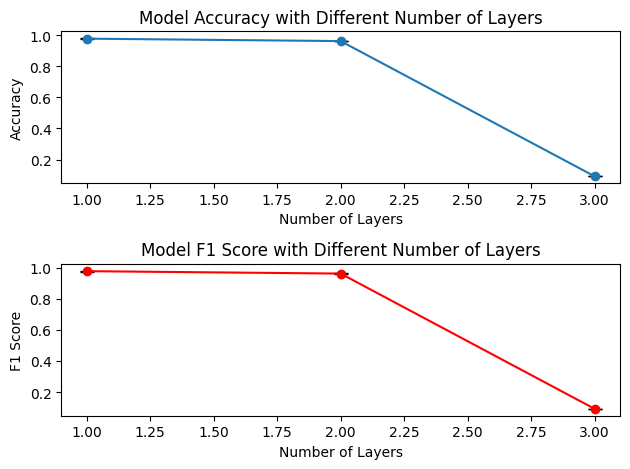

In [30]:
#wykres i excel z wynikami, ilość warstw
layers = range(1, len(layer_dims)+1)

fig, axs = plt.subplots(2)

# Wykres dla Accuracy
axs[0].errorbar(layers, combined_accuracy, yerr=combined_accuracy_mse, fmt='-o', ecolor='black', capsize=5) 
axs[0].set_title('Model Accuracy with Different Number of Layers')
axs[0].set_xlabel('Number of Layers')
axs[0].set_ylabel('Accuracy')

# Wykres dla F1
axs[1].errorbar(layers, combined_f1, yerr=combined_f1_mse, fmt='-o', ecolor='black', color='red', capsize=5)    
axs[1].set_title('Model F1 Score with Different Number of Layers')
axs[1].set_xlabel('Number of Layers')
axs[1].set_ylabel('F1 Score')

# Wyświetl wykresy
plt.tight_layout()
plt.show()

# Zapisz wykresy
fig.savefig('layers_separate.png')

df = pd.DataFrame({
    'Accuracy': combined_accuracy,
    'F1': combined_f1,
    'Accuracy MSE': combined_accuracy_mse,
    'F1 MSE': combined_f1_mse
})


df.to_excel("model_performance_layers.xlsx", index=False)

In [33]:
#eksperyment rozmiar batch_size
layer_dims = [64, 16, 16, 10]
batches = [8, 16, 32, 64]
learning_rate = 0.01
num_epochs = 5000
combined_accuracy = []
combined_f1 = []
combined_accuracy_mse = []
combined_f1_mse = []
for batch in batches:
    model_accuracy = []
    model_f1 = []
    for i in range(0, 5):
        parameters = initialize_parameters(layer_dims)
        print(f"Batch size: {batch}")
        parameters = train(X_train, y_train_one_hot, layer_dims, learning_rate, num_epochs, batch, activation_func=relu, activation_derivative=relu_derivative)
        accuracy, f1 = evaluate(X_test, y_test_one_hot, parameters, relu)
        print(f"Test Accuracy: {accuracy:.4f}, Test F1 Score: {f1:.4f}\n")
        model_accuracy.append(accuracy)
        model_f1.append(f1)
    print(model_accuracy)
    combined_accuracy.append(np.mean(model_accuracy))
    combined_f1.append(np.mean(model_f1))
    combined_accuracy_mse.append(np.std(model_accuracy))
    combined_f1_mse.append(np.std(model_f1))


Batch size: 8
Epoch 0 - Accuracy: 0.0000, F1 Score: 0.0000
Epoch 100 - Accuracy: 0.0000, F1 Score: 0.0000
Epoch 200 - Accuracy: 1.0000, F1 Score: 1.0000
Epoch 300 - Accuracy: 0.0000, F1 Score: 0.0000
Epoch 400 - Accuracy: 1.0000, F1 Score: 1.0000
Epoch 500 - Accuracy: 1.0000, F1 Score: 1.0000
Epoch 600 - Accuracy: 1.0000, F1 Score: 1.0000
Epoch 700 - Accuracy: 1.0000, F1 Score: 1.0000
Epoch 800 - Accuracy: 1.0000, F1 Score: 1.0000
Epoch 900 - Accuracy: 1.0000, F1 Score: 1.0000
Epoch 1000 - Accuracy: 1.0000, F1 Score: 1.0000
Epoch 1100 - Accuracy: 1.0000, F1 Score: 1.0000
Epoch 1200 - Accuracy: 1.0000, F1 Score: 1.0000
Epoch 1300 - Accuracy: 1.0000, F1 Score: 1.0000
Epoch 1400 - Accuracy: 1.0000, F1 Score: 1.0000
Epoch 1500 - Accuracy: 1.0000, F1 Score: 1.0000
Epoch 1600 - Accuracy: 1.0000, F1 Score: 1.0000
Epoch 1700 - Accuracy: 1.0000, F1 Score: 1.0000
Epoch 1800 - Accuracy: 1.0000, F1 Score: 1.0000
Epoch 1900 - Accuracy: 1.0000, F1 Score: 1.0000
Epoch 2000 - Accuracy: 1.0000, F1 Scor

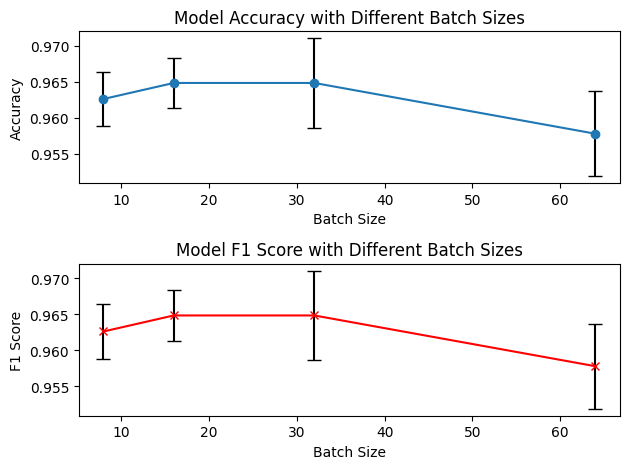

In [34]:
fig, axs = plt.subplots(2)

# Wykres dla Accuracy
axs[0].errorbar(batches, combined_accuracy, yerr=combined_accuracy_mse, fmt='-o', ecolor='black', capsize=5)
axs[0].set_title('Model Accuracy with Different Batch Sizes')
axs[0].set_xlabel('Batch Size')
axs[0].set_ylabel('Accuracy')

# Wykres dla F1
axs[1].errorbar(batches, combined_f1, yerr=combined_f1_mse, fmt='-x', ecolor='black', color='red', capsize=5)
axs[1].set_title('Model F1 Score with Different Batch Sizes')
axs[1].set_xlabel('Batch Size')
axs[1].set_ylabel('F1 Score')

# Wyświetl wykresy
plt.tight_layout()
plt.show()

# Zapisz wykresy
fig.savefig('batch_size_separate.png')


df = pd.DataFrame({
    'Accuracy': combined_accuracy,
    'F1': combined_f1,
    'Accuracy MSE': combined_accuracy_mse,
    'F1 MSE': combined_f1_mse
})


df.to_excel("model_performance_batch_size.xlsx", index=False)

